## Загрузка данных

In [2]:
!pip install -q skorch

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
from torch import tensor
from torch.optim import Adam

from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring, EarlyStopping


from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from math import ceil
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

SEED = np.random.RandomState(0) # стандратное значение
torch.manual_seed(3826)


In [3]:
data= pd.read_csv('/datasets/6_class.csv', index_col=0) 

In [4]:
display(data.head())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [5]:
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [6]:
print(data.info())
print()
print(data.duplicated().sum())
print(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB
None

0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64


## Предобработка и анализ данных

In [7]:
data['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Yellowish White         3
white                   3
Blue white              3
yellowish               2
Orange                  2
Whitish                 2
Pale yellow orange      1
Blue white              1
Blue-White              1
Orange-Red              1
Yellowish               1
White-Yellow            1
Blue                    1
Name: Star color, dtype: int64

In [8]:
data['Star color'] = data['Star color'].replace({'Blue White': 'Blue-white', 'Blue white':'Blue-white',
                                             'Blue white ':'Blue-white','Blue-White':'Blue-white',
                                             'Blue ':'Blue', 'white':'White', 'yellowish':'Yellowish',
                                             'yellow-white':'Yellow-white','White-Yellow':'Yellow-white',
                                             'Yellowish White':'Yellow-white','Pale yellow orange':'Pale-yellow-orange',
                                             'Whitish':'White'})

In [9]:
data['Star color'].value_counts()

Red                   112
Blue                   56
Blue-white             41
White                  12
Yellow-white           12
Yellowish               3
Orange                  2
Orange-Red              1
Pale-yellow-orange      1
Name: Star color, dtype: int64

In [10]:
list_drop = ['Pale-yellow-orange', 'Orange-Red', 'Orange', 'Yellowish']
data = data.drop(data[data['Star color'].isin(list_drop)].index)
print(data['Star color'].value_counts())

Red             112
Blue             56
Blue-white       41
White            12
Yellow-white     12
Name: Star color, dtype: int64


<AxesSubplot:>

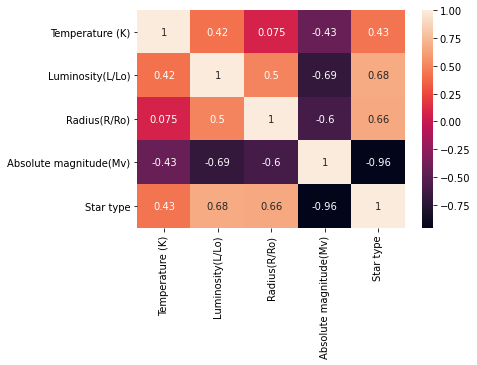

In [11]:
sns.heatmap(data.corr(),annot=True)

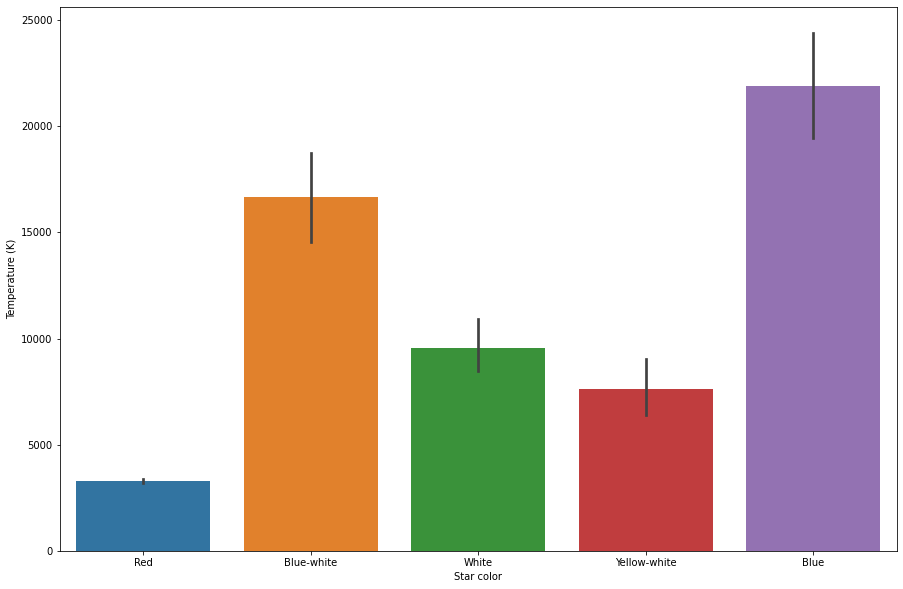

In [12]:
ax=sns.barplot(data=data,x='Star color',y='Temperature (K)')
ax.figure.set_size_inches(15,10)

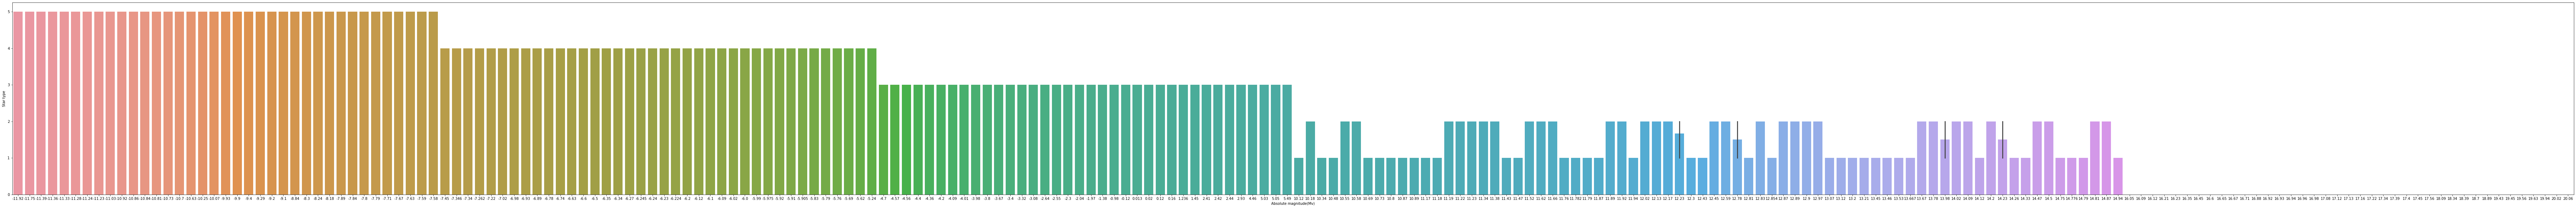

In [13]:
ax=sns.barplot(data=data,x='Absolute magnitude(Mv)',y='Star type')
ax.figure.set_size_inches(130,10)

как показывает график, есть прямая зависимость между абсолютной звездной величеной и типом звезды. Так в диапозоне от -11.92 до -7. 58 здезды имеют 5 тип т.е Гипергиганты, от -7.45 до -5.24 звезды имеют 4 тип т.е Сверхгиганты, от -4.7 до 5.49 здезды имеют 3 тип т.е. Звёзды главной последовательности, в диапазоне от 10.12 до14.94 здезды имеют типы 1 и 2 т.е. Белый карлик и Красный карлик. все звезды больше этого значения имеют 0 тип т.е. Коричневый карлик.

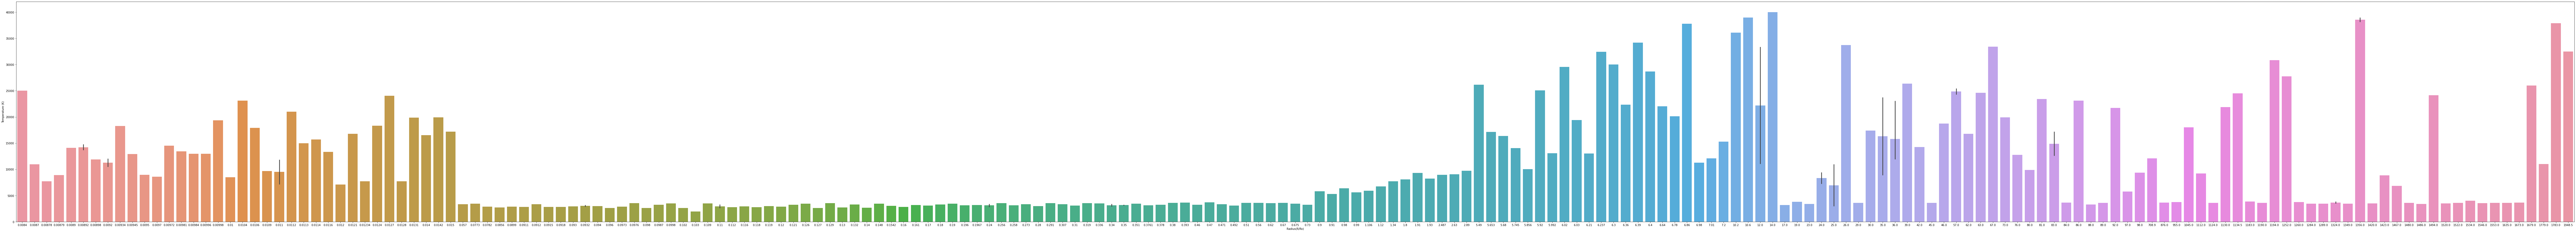

In [14]:
ax=sns.barplot(data=data,x='Radius(R/Ro)',y='Temperature (K)')
ax.figure.set_size_inches(170,15)

график показывает, что радиус не сильно зависит от температуры звезды 

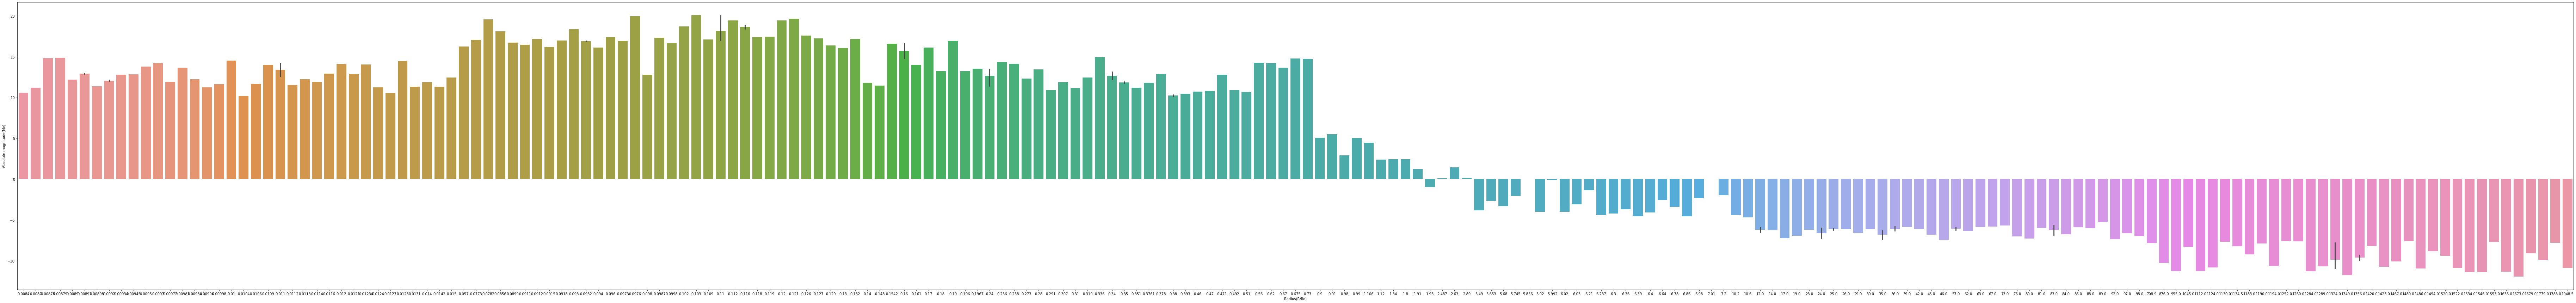

In [15]:
ax=sns.barplot(data=data,x='Radius(R/Ro)',y='Absolute magnitude(Mv)')
ax.figure.set_size_inches(130,15)

на графике четко видно, что здезды задусом от 0.0084 до 1.93 имеют положительную магнитуду блеска звезды, а начиная с 5.49 и до 1948.5 здезды имеют отрицательную магнитуду блеска, в диапазоне от 1.93 до 2.89 наблюдаются аномалии в магентуде блеска звезды.

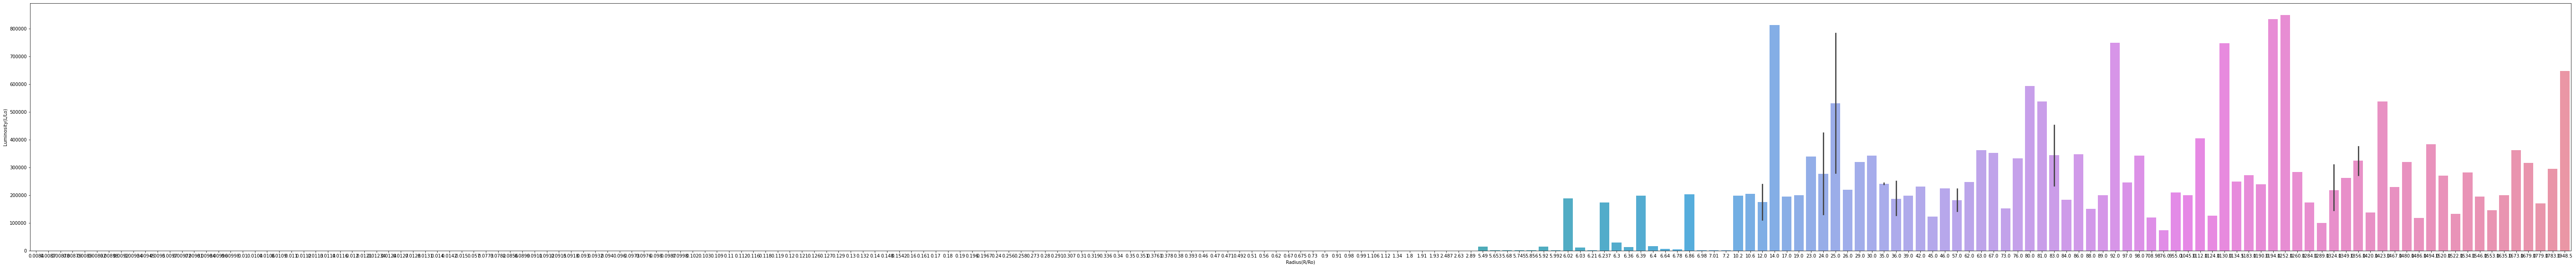

In [16]:
ax=sns.barplot(data=data,x='Radius(R/Ro)',y='Luminosity(L/Lo)')
ax.figure.set_size_inches(100,10)

на графике видна зависимость светимости звезды от ее радиуса

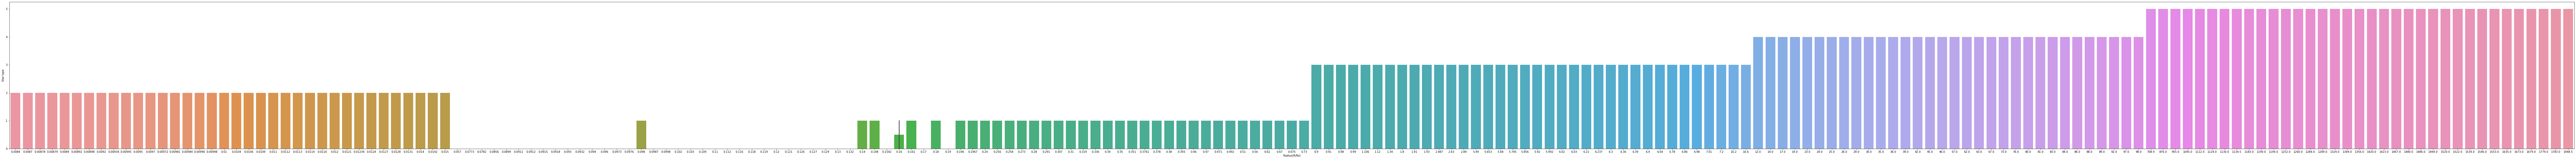

In [17]:
ax=sns.barplot(data=data,x='Radius(R/Ro)',y='Star type')
ax.figure.set_size_inches(170,10)

в диапазоне от 0.0084 до 0.015  звезды имеют 2 тип, от  0.196 до 0.9 здезды имеют 1 тип, с 0.057 до 0.19 здезды имеют 0 тип (не включая аномалии), от 0.9 значиния до 12 звезды имеют 3 тип, с 14 до 708.9 это 4 тип звезд, с 876 до конца грфика это 5 тип звезд.

### разделение  и переработка данных

In [18]:
features = data.drop('Temperature (K)', axis=1)
target = data['Temperature (K)']

In [19]:
features_train, features_test, target_train, target_test = train_test_split(features.copy(), target.copy(),
                                                                            test_size=.2, shuffle=True, 
                                                                            random_state=SEED)

display(features_train.shape, features_test.shape)
display(target_train.shape, target_test.shape)

(186, 5)

(47, 5)

(186,)

(47,)

In [20]:
numeric_features = ["Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)"]
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())  # Масштабирование числовых признаков
])

In [21]:
# Создание трансформера для кодирования категориальных признаков
categorical_features = ["Star color","Star type"]
categorical_transformer = Pipeline(steps=[
    ("label_encoder", OneHotEncoder(sparse=False))  # Кодирование категориальных признаков
])

In [22]:
# Объединение трансформеров в один
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

In [23]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
])

In [24]:
features_train_transformed = pipeline.fit_transform(features_train)
features_test_transformed = pipeline.transform(features_test)

## Построение базовой нейронной сети

In [25]:
# Создадим тензоры
X_train = torch.Tensor(features_train_transformed)
X_test = torch.Tensor(features_test_transformed)

y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

In [26]:
print('Кол-во строк и столбцов в X_train выборке:', X_train.shape)
print('Кол-во строк и столбцов в X_test выборке:', X_test.shape)

print('Кол-во строк и столбцов в y_train выборке:', y_train.shape)
print('Кол-во строк и столбцов в y_test выборке:', y_test.shape)

Кол-во строк и столбцов в X_train выборке: torch.Size([186, 14])
Кол-во строк и столбцов в X_test выборке: torch.Size([47, 14])
Кол-во строк и столбцов в y_train выборке: torch.Size([186])
Кол-во строк и столбцов в y_test выборке: torch.Size([47])


In [27]:
# параметры слоев сети
n_in_neurons = 14
n_hidden_neurons_1 = 7
n_hidden_neurons_2 = 10
n_out_neurons = 1

In [28]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()
        
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=0, std=sqrt(2/n_hidden_neurons_1))
        nn.init.kaiming_uniform_(self.fc3.weight)
        nn.init.normal_(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act1(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [29]:
# Укажем параметры сети
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
num_epochs = 1000
batch_size = 20
num_batches = ceil(len(X_train)/batch_size)

In [30]:
# Найдем значение RMSE
df= {'epoch':[] ,'rmse':[]}
total_step = len(X_train)
for epoch in range(num_epochs):
    net.train()
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(X_train))
        optimizer.zero_grad()
        
        batch_indexes = order[start_idx:start_idx+batch_size]
        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]
        
        preds_train = net.forward(X_batch)
       
        loss_value_train = torch.sqrt(loss(preds_train, y_batch))
        loss_value_train.backward()
                
        optimizer.step()
    if (epoch+1) % 10 == 0 or epoch == num_epochs:
        
        
        net.eval()
        with torch.no_grad():
            for batch_idx in X_test:
                preds_test = net.forward(X_test).flatten()
                RMSE_loss = torch.sqrt(loss(preds_test, y_test))
        print ('Эпоха [{}/{}], Значение функции потерь: {:.4f}'
            .format(epoch+1, num_epochs, RMSE_loss.item()))
        df['epoch'].append(epoch+1)
        df['rmse'].append(RMSE_loss.item())
        
pivot= pd.DataFrame(data=df)        

print(pivot.head())


Эпоха [10/1000], Значение функции потерь: 14549.7461
Эпоха [20/1000], Значение функции потерь: 11641.0010
Эпоха [30/1000], Значение функции потерь: 9595.6182
Эпоха [40/1000], Значение функции потерь: 9469.9209
Эпоха [50/1000], Значение функции потерь: 9442.3545
Эпоха [60/1000], Значение функции потерь: 9429.6855
Эпоха [70/1000], Значение функции потерь: 9422.6250
Эпоха [80/1000], Значение функции потерь: 9418.1455
Эпоха [90/1000], Значение функции потерь: 9413.8770
Эпоха [100/1000], Значение функции потерь: 9410.5938
Эпоха [110/1000], Значение функции потерь: 9407.7432
Эпоха [120/1000], Значение функции потерь: 9404.8408
Эпоха [130/1000], Значение функции потерь: 9401.7100
Эпоха [140/1000], Значение функции потерь: 9398.3184
Эпоха [150/1000], Значение функции потерь: 9394.6133
Эпоха [160/1000], Значение функции потерь: 9391.0801
Эпоха [170/1000], Значение функции потерь: 9387.2568
Эпоха [180/1000], Значение функции потерь: 9383.5049
Эпоха [190/1000], Значение функции потерь: 9379.8477


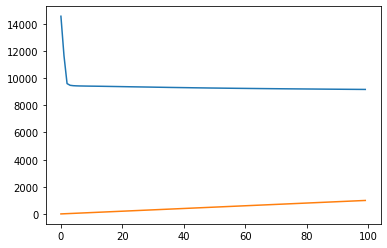

In [33]:
#sns.lineplot(data=pivot,x= 'rmse',y= 'epoch')
plt.plot(pivot['rmse'])
plt.plot(pivot['epoch'])

plt.show()

In [34]:
RMSE_loss

tensor(9166.2441)

In [35]:
def graph(x, y):
        
    barWidth1 = 1
    barWidth2 = 0.5
    x_range = np.arange(len(y))

    plt.figure(figsize=(40, 20))

    # Построение столбчатой диаграммы для фактических данных
    plt.bar(x_range, y.data.numpy(),width=barWidth1/2, color='blue', label='Фактические данные')
    # Построение столбчатой диаграммы для предсказанных данных с смещением
    plt.bar(x_range, x.data.numpy(), width=barWidth2/2, color='red', label='Предсказанные данные')

    # Установка меток на оси X
    plt.xticks(x_range + 0.2, x_range)
    plt.xlabel('Температура звезды')
    plt.ylabel('Номер звезды в таблице данных')
    plt.title('Столбчатая диаграмма Фактических и Предсказанных данных')

    # Отображение графика
    plt.rcParams.update({'font.size': 28})    
    plt.box(False)
    plt.savefig('plt', bbox_inches = "tight")
    plt.show()

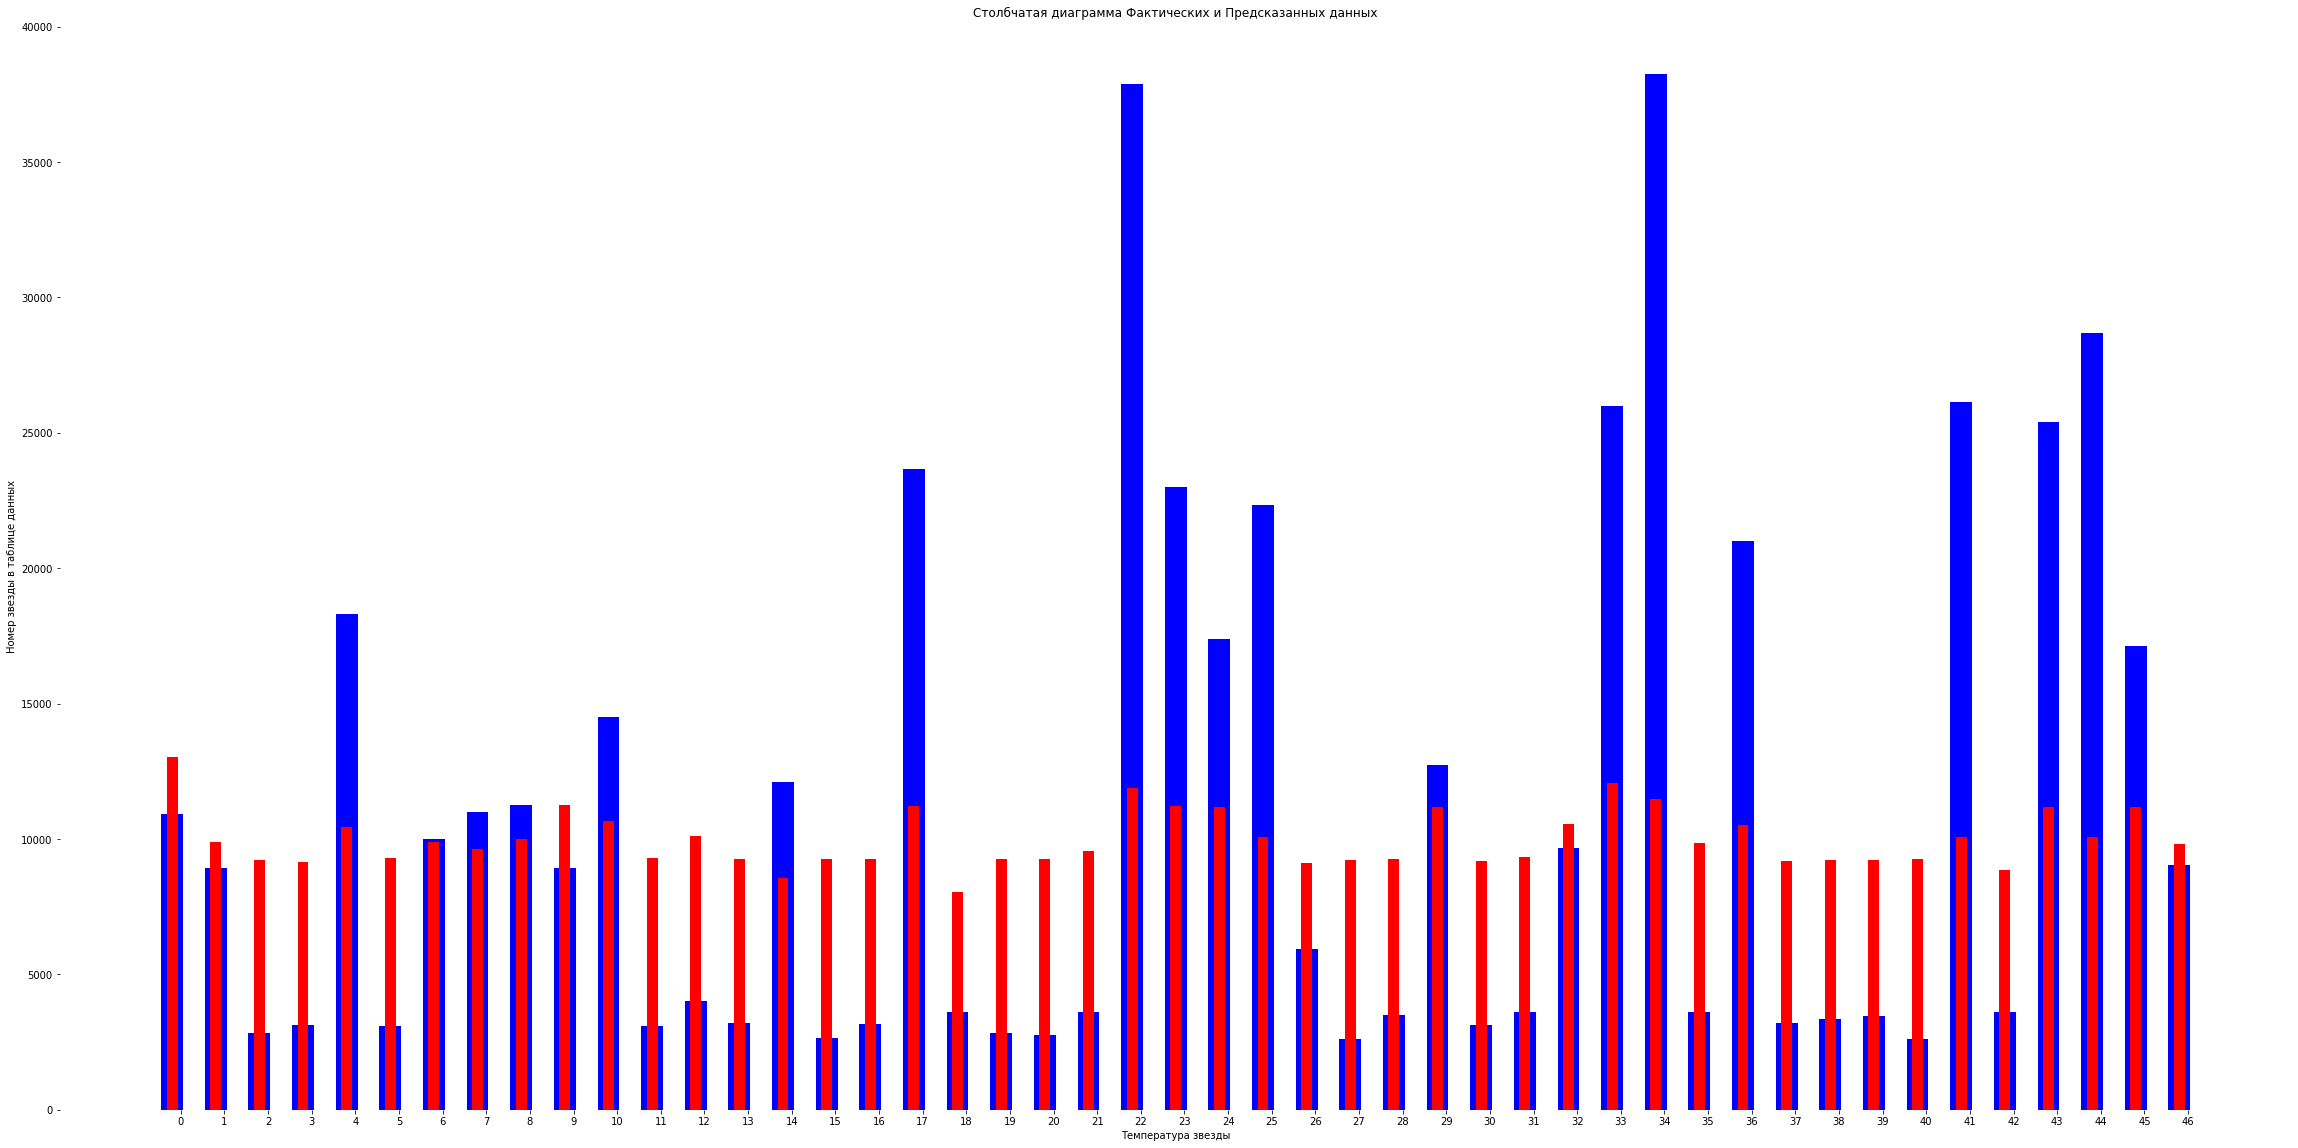

In [36]:
graph(preds_test, y_test)

## Улучшение нейронной сети

In [ ]:
X_train_up = tensor(X_train, dtype=torch.float32)
X_test_up = tensor(X_test, dtype=torch.float32)

y_train_up = tensor(y_train.reshape(-1,1), dtype=torch.float32)
y_test_up = tensor(y_test.reshape(-1,1), dtype=torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
class Model_improve(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 
                 dropout_1, dropout_2, activation_1, activation_2, activation_3):
        super(Model_improve, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = activation_1
        self.dp1 = nn.Dropout(dropout_1)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = activation_2
        self.dp2 = nn.Dropout(dropout_2)
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = activation_3
        
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
        
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=0, std=sqrt(2/n_hidden_neurons_1))
       
        nn.init.kaiming_uniform_(self.fc3.weight)
        nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [ ]:
net = Model_improve(n_in_neurons, n_hidden_neurons_1, 36, n_out_neurons, 
                    0.8, 0.5, nn.ReLU(), nn.ReLU(), nn.ReLU())

In [ ]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

skorch_regressor = NeuralNetRegressor(module=net, 
                                      device='cpu',  
                                      verbose=10,
                                      batch_size=40,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=1000, 
                                      lr=0.01,
                                      criterion=torch.nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=5))
            ], 
                                     )

In [ ]:
skorch_regressor.fit(X_train_up, y_train_up)

In [ ]:
ep = skorch_regressor.history[:, 'epoch']
r = skorch_regressor.history[:, 'RMSE']

plt.plot(ep)
plt.plot(r)

plt.xlabel('rmse')
plt.ylabel('epoch')

plt.legend(r,ep)
plt.show()

In [ ]:
print("Train RMSE : {}".format(sqrt(mean_squared_error(y_train_up, skorch_regressor.predict(X_train).reshape(-1)))))
print("Test  RMSE : {}".format(sqrt(mean_squared_error(y_test_up, skorch_regressor.predict(X_test).reshape(-1)))))

In [ ]:
params = {
    'module__n_in_neurons':[14],
    'module__n_hidden_neurons_1': range(1, 150, 5),
    'module__n_hidden_neurons_2': range(1, 150, 5),
    'module__n_out_neurons':[1],
    'module__dropout_1': [0, 0.2, 0.4, 0.6, 0.8],
    'module__dropout_2': [0, 0.2, 0.4, 0.6, 0.8],
    'module__activation_1': [nn.LeakyReLU(), nn.ReLU(), nn.Tanh(), nn.ELU()],
    'module__activation_2': [nn.LeakyReLU(), nn.ReLU(), nn.Tanh(), nn.ELU()],
    'module__activation_3': [nn.LeakyReLU(), nn.ReLU(), nn.Tanh(), nn.ELU()],
    'lr': [0.1,0.01, 0.001,0.0001]
}

In [ ]:
grid = RandomizedSearchCV(skorch_regressor, params, cv=3, scoring="neg_root_mean_squared_error", 
                          verbose=3, random_state=123)
param = grid.fit(X_train_up, y_train_up.reshape(-1,1))

In [ ]:
param.best_params_

In [ ]:
pred = grid.predict(X_test_up)

In [ ]:
Train_RMSE = sqrt(mean_squared_error(y_train_up, grid.predict(X_train_up).reshape(-1)))
Test_RMSE  = sqrt(mean_squared_error(y_test_up, grid.predict(X_test_up).reshape(-1)))

In [ ]:
print("Train RMSE : {}".format(Train_RMSE))
print("Test  RMSE : {}".format(Test_RMSE))

In [ ]:
graph(tensor(pred.reshape(-1)), y_test)

## Выводы

Базовая модель нейронной сети с параметрами n_hidden_neurons_1 = 7, n_hidden_neurons_2 = 10 показала значение RMSE 7579. Улучшили модель, используя перебор количества нейронов в скрытых слоях, а также используем BatchNorm и Dropout. Установили следующие параметры:

    n_in_neurons = 14
    n_hidden_neurons_1 = 61
    n_hidden_neurons_2 = 141
    dropout_1 = 0.8
    dropout_2 = 0
    BatchNorn = 61
    BatchNorn_2 = 141
    n_out_neurons = 1
функция активации после каждого слоя:
    ELU, ReLU, ELU.
Также для настройки модели использовали EarlyStopping. С данными параметрами нейронной сети мы достигли значения RMSE 4207.